## Base imports

In [1]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math

import pandas as pd


try:
    import cPickle as pickle
except:
    import pickle
    

from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import matplotlib




In [2]:
torch.cuda.empty_cache()
image_trans_size = 64
batch_size = 10
nb_epochs = 200

## Some utility functions

In [3]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)

from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import sys

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
    
import torch.utils.data as data
from PIL import Image
import numpy as np
import h5py



## Dataloader functions

In [4]:
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

## Base network wrapper

In [5]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

# Our special classes

## Priors classes

In [6]:
class laplace_prior(object):
    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def loglike(self, x, do_sum=True):
        if do_sum:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b).sum()
        else:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b)

class isotropic_gauss_prior(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
        self.cte_term = -(0.5)*np.log(2*np.pi)
        self.det_sig_term = -np.log(self.sigma)

    def loglike(self, x, do_sum=True):
        
        dist_term = -(0.5)*((x - self.mu)/self.sigma)**2
        if do_sum:
            return (self.cte_term + self.det_sig_term + dist_term).sum()
        else:
            return (self.cte_term + self.det_sig_term + dist_term)
    

# TODO: adapt so can be done without sum
class spike_slab_2GMM(object):
    def __init__(self, mu1, mu2, sigma1, sigma2, pi):
        
        self.N1 = isotropic_gauss_prior(mu1, sigma1)
        self.N2 = isotropic_gauss_prior(mu2, sigma2)
        
        self.pi1 = pi 
        self.pi2 = (1-pi)

    def loglike(self, x):
        
        N1_ll = self.N1.loglike(x)
        N2_ll = self.N2.loglike(x)
        
        # Numerical stability trick -> unnormalising logprobs will underflow otherwise
        max_loglike = torch.max(N1_ll, N2_ll)
        normalised_like = self.pi1 + torch.exp(N1_ll - max_loglike) + self.pi2 + torch.exp(N2_ll - max_loglike)
        loglike = torch.log(normalised_like) + max_loglike
    
        return loglike
    

## Weight layers

In [7]:
def isnan(tensor):
  # Gross: https://github.com/pytorch/pytorch/issues/4767
    return (tensor != tensor)

def hasnan(tensor):
    return isnan(tensor).any()

def isotropic_gauss_loglike(x, mu, sigma, do_sum=True):
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    
    if do_sum:
        out = (cte_term + det_sig_term + dist_term).sum() # sum over all weights
    else:
        out = (cte_term + det_sig_term + dist_term)
#     print(hasnan(x.data), hasnan(mu.data), hasnan(sigma.data), out)
#     if isnan(out) or hasnan(out):
#         print('NAaaanNNN')
#         print('mu max', mu.max())
#         print('mu min', mu.min())
#         print('sigma max', sigma.max())
#         print('sigma min', sigma.min())
#         print('x max', x.max())
#         print('x min', x.min())
#         print((x - mu).max())
#         print((x - mu).min())
#         print(hasnan(inner))
#         print(dist_term)
#         print(hasnan(dist_term))
    return out 



class BayesLinear_Normalq(nn.Module):
    def __init__(self, n_in, n_out, prior_class):
        super(BayesLinear_Normalq, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.prior = prior_class
        
        # Learnable parameters
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.2, 0.2))
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-3, -2))
        
        self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.2, 0.2))
        self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-3, -2))
        
       
        self.lpw = 0
        self.lqw = 0
        
                                   
    def forward(self, X, sample=False):
#         print(self.training)

        if not self.training and not sample: # This is just a placeholder function
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
            return output, 0, 0
                                       
        else:
                              
            # Tensor.new()  Constructs a new tensor of the same data type as self tensor. 
            # the same random sample is used for every element in the minibatch
            eps_W = Variable(self.W_mu.data.new(self.W_mu.size()).normal_())
            eps_b = Variable(self.b_mu.data.new(self.b_mu.size()).normal_())
                                       
            # sample parameters         
            
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
            std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)                      
                                   
            W = self.W_mu + 1 * std_w * eps_W
            b = self.b_mu + 1 * std_b * eps_b          
    
            
            output = torch.mm(X, W) + b.unsqueeze(0).expand(X.shape[0], -1) # (batch_size, n_output)
            
            lqw = isotropic_gauss_loglike(W, self.W_mu, std_w) + isotropic_gauss_loglike(b, self.b_mu, std_b)
            lpw = self.prior.loglike(W) + self.prior.loglike(b)
            return output, lqw, lpw

            

### Quick weight sampling function for plotting

In [8]:
def sample_weights(W_mu, b_mu, W_p, b_p):
    
    eps_W = W_mu.data.new(W_mu.size()).normal_()
    # sample parameters         
    std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)     
    W = W_mu + 1 * std_w * eps_W
    
    if b_mu is not None:
        std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)  
        eps_b = b_mu.data.new(b_mu.size()).normal_()
        b = b_mu + 1 * std_b * eps_b
    else:
        b = None
    
    return W, b

## Our models

In [9]:
class bayes_linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(bayes_linear_2L, self).__init__()
        
        n_hid = 1200
#         prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
#         prior_instance = spike_slab_2GMM(mu1=0, mu2=0, sigma1=0.135, sigma2=0.001, pi=0.5)
        self.prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bfc1 = BayesLinear_Normalq(input_dim, n_hid, self.prior_instance)
        self.bfc2 = BayesLinear_Normalq(n_hid, n_hid, self.prior_instance)
        self.bfc3 = BayesLinear_Normalq(n_hid, output_dim, self.prior_instance)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=False):
        
        tlqw = 0
        tlpw = 0
        
        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x, lqw, lpw = self.bfc1(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        x, lqw, lpw = self.bfc2(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        y, lqw, lpw = self.bfc3(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        
        return y, tlqw, tlpw
    
    def sample_predict(self, x, Nsamples):
        
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        tlqw_vec = np.zeros(Nsamples)
        tlpw_vec = np.zeros(Nsamples)
        
        for i in range(Nsamples):
            
            y, tlqw, tlpw = self.forward(x, sample=True)
            predictions[i] = y
            tlqw_vec[i] = tlqw
            tlpw_vec[i] = tlpw 
            
        return predictions, tlqw_vec, tlpw_vec
        

## Network wrapper

In [10]:
from __future__ import division
import copy

class Bayes_Net(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=1, side_in=128, cuda=True, classes=2, batch_size=128, Nbatches=0):
        super(Bayes_Net, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.classes = classes
        self.batch_size = batch_size
        self.Nbatches = Nbatches
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = bayes_linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y, samples=1):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        if samples == 1:
            out, tlqw, tlpw = self.model(x)
            mlpdw = F.cross_entropy(out, y, reduction='sum')
            Edkl = (tlqw - tlpw)/self.Nbatches
            
        elif samples > 1:
            mlpdw_cum = 0
            Edkl_cum = 0
            
            for i in range(samples):
                out, tlqw, tlpw = self.model(x, sample=True)
                mlpdw_i = F.cross_entropy(out, y, reduction='sum')
                Edkl_i = (tlqw - tlpw)/self.Nbatches
                mlpdw_cum = mlpdw_cum + mlpdw_i
                Edkl_cum = Edkl_cum + Edkl_i 
            
            mlpdw = mlpdw_cum/samples
            Edkl = Edkl_cum/samples
        
        loss = Edkl + mlpdw
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return Edkl.data, mlpdw.data, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    
    def get_weight_samples(self, Nsamples=10):
        state_dict = self.model.state_dict()
        weight_vec = []
        
        for i in range(Nsamples):
            previous_layer_name = ''
            for key in state_dict.keys():
                layer_name = key.split('.')[0]
                if layer_name != previous_layer_name:
                    previous_layer_name = layer_name

                    W_mu = state_dict[layer_name+'.W_mu'].data
                    W_p = state_dict[layer_name+'.W_p'].data

    #                 b_mu = state_dict[layer_name+'.b_mu'].cpu().data
    #                 b_p = state_dict[layer_name+'.b_p'].cpu().data

                    W, b = sample_weights(W_mu=W_mu, b_mu=None, W_p=W_p, b_p=None)

                    for weight in W.cpu().view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)
    
    def get_weight_SNR(self, thresh=None):
        state_dict = self.model.state_dict()
        weight_SNR_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                sig_W = 1e-6 + F.softplus(W_p, beta=1, threshold=20)

                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                sig_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                W_snr = (torch.abs(W_mu)/sig_W)
                b_snr = (torch.abs(b_mu)/sig_b)
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = W_snr > thresh
                    mask_dict[layer_name+'.b'] = b_snr > thresh
                    
                else:
                
                    for weight_SNR in W_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

                    for weight_SNR in b_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)
        
        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_SNR_vec)
    
    
    def get_weight_KLD(self, Nsamples=20, thresh=None):
        state_dict = self.model.state_dict()
        weight_KLD_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                
                std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)  
                std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                KL_W = W_mu.new(W_mu.size()).zero_()
                KL_b = b_mu.new(b_mu.size()).zero_()
                for i in range(Nsamples):
                    W, b = sample_weights(W_mu=W_mu, b_mu=b_mu, W_p=W_p, b_p=b_p)  
                    # Note that this will currently not work with slab and spike prior
                    KL_W += isotropic_gauss_loglike(W, W_mu, std_w, do_sum=False) - self.model.prior_instance.loglike(W, do_sum=False)
                    KL_b += isotropic_gauss_loglike(b, b_mu, std_b, do_sum=False) - self.model.prior_instance.loglike(b, do_sum=False)

                KL_W /= Nsamples
                KL_b /= Nsamples
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = KL_W > thresh
                    mask_dict[layer_name+'.b'] = KL_b > thresh
                    
                else:

                    for weight_KLD in KL_W.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

                    for weight_KLD in KL_b.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)
        
        if thresh is not None:
            return mask_dict
        else:    
            return np.array(weight_KLD_vec)
        
        
    def mask_model(self, Nsamples=0, thresh=0):
        '''
        Nsamples is used to select SNR (0) or KLD (>0) based masking
        '''
        original_state_dict = copy.deepcopy(self.model.state_dict())
        state_dict = self.model.state_dict()
        
        if Nsamples == 0:
            mask_dict = self.get_weight_SNR(thresh=thresh)
        else:
            mask_dict = self.get_weight_KLD(Nsamples=Nsamples, thresh=thresh)
        
        n_unmasked = 0
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name
                
                state_dict[layer_name+'.W_mu'][1-mask_dict[layer_name+'.W']] = 0
                state_dict[layer_name+'.W_p'][1-mask_dict[layer_name+'.W']] = -1000
                
                state_dict[layer_name+'.b_mu'][1-mask_dict[layer_name+'.b']] = 0
                state_dict[layer_name+'.b_p'][1-mask_dict[layer_name+'.b']] = -1000
                
                
                n_unmasked += mask_dict[layer_name+'.W'].sum()
                n_unmasked += mask_dict[layer_name+'.b'].sum()
                
        return original_state_dict, n_unmasked
            
            
            
        
            
    

In [11]:


transform_covid19 = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=(0, 180)),
        transforms.Resize(image_trans_size),
        transforms.CenterCrop(image_trans_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1)
])
    
    
trainset = torchvision.datasets.ImageFolder(root="../data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="../data/COVID/test", transform=transform_covid19)
num_classes = 2
inputs = 3

In [12]:
k15 = trainset[0][0].cpu().numpy()
k15 = np.concatenate(k15)
k15

array([[-2.0163302, -2.0163302, -2.0163302, ..., -2.0163302, -2.0163302,
        -2.0163302],
       [-2.0163302, -2.0163302, -2.0163302, ..., -2.0163302, -2.0163302,
        -2.0163302],
       [-2.0163302, -2.0163302, -2.0163302, ..., -1.8077447, -1.9641838,
        -2.0163302],
       ...,
       [ 1.7729735,  1.7729735,  1.7729735, ...,  1.7555914,  1.7382094,
         1.6860629],
       [ 1.7729735,  1.7729735,  1.7729735, ...,  1.7555914,  1.7555914,
         1.7208272],
       [ 1.7729735,  1.7729735,  1.7729735, ...,  1.7555914,  1.7555914,
         1.7208272]], dtype=float32)

In [13]:
trainset.class_to_idx

{'0noncovid': 0, '1covid': 1}

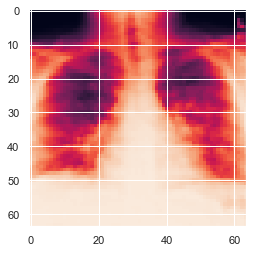

In [14]:
plt.imshow(k15)

In [15]:
# print(net.model.state_dict()['bfc1.W_mu'].cpu().data)

In [16]:
# import copy
# aaa = copy.deepcopy(net.model)
# net.model = aaa

In [17]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib
import copy


models_dir = 'models_weight_uncertainty_COVID150_gaussian'
results_dir = 'results_weight_uncertainty_COVID150_gaussian'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 300

log_interval = 1

savemodel_its = [20, 50, 80, 100]
save_dicts = []

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

use_cuda = torch.cuda.is_available()

# trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
# valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-6
nsamples = 3
########################################################################################
net = Bayes_Net(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=2, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))

epoch = 0

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_dkl, cost_pred, err = net.fit(x, y, samples=nsamples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # Save state dict
    
    if i in savemodel_its:
        save_dicts.append(copy.deepcopy(net.model.state_dict()))
    
    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', kl_cost_train)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5



 


Data:

Network:

Net:
 Creating Net!! 
    Total params: 12.72M

Train:


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_24556/2912214083.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


  init cost variables:
it 0/200, Jtr_KL = 16219.443333, Jtr_pred = 49.268011, err = 0.486667,    time: 8.586152 seconds

    Jdev = 26.613043, err = 0.575000

best test error
Writting models_weight_uncertainty_COVID150_gaussian/theta_best.dat

it 1/200, Jtr_KL = 16214.105000, Jtr_pred = 53.040413, err = 0.480000,    time: 6.490517 seconds

    Jdev = 26.174121, err = 0.550000

best test error
Writting models_weight_uncertainty_COVID150_gaussian/theta_best.dat

it 2/200, Jtr_KL = 16213.983333, Jtr_pred = 55.331165, err = 0.510000,    time: 6.633598 seconds

    Jdev = 25.296153, err = 0.575000

it 3/200, Jtr_KL = 16208.996667, Jtr_pred = 54.232861, err = 0.526667,    time: 6.710194 seconds

    Jdev = 25.159546, err = 0.575000

it 4/200, Jtr_KL = 16206.258333, Jtr_pred = 46.061696, err = 0.453333,    time: 6.788176 seconds

    Jdev = 24.868794, err = 0.575000

it 5/200, Jtr_KL = 16205.335000, Jtr_pred = 50.164287, err = 0.460000,    time: 6.744766 seconds

    Jdev = 24.716502, err = 0

    Jdev = 20.122919, err = 0.387500

it 47/200, Jtr_KL = 16084.833333, Jtr_pred = 37.274629, err = 0.386667,    time: 6.798202 seconds

    Jdev = 19.978815, err = 0.387500

it 48/200, Jtr_KL = 16083.751667, Jtr_pred = 37.461491, err = 0.380000,    time: 6.809674 seconds

    Jdev = 19.845212, err = 0.362500

best test error
Writting models_weight_uncertainty_COVID150_gaussian/theta_best.dat

it 49/200, Jtr_KL = 16081.013333, Jtr_pred = 38.081156, err = 0.416667,    time: 6.753200 seconds

    Jdev = 19.828314, err = 0.362500

it 50/200, Jtr_KL = 16076.161667, Jtr_pred = 34.332630, err = 0.373333,    time: 6.181914 seconds

    Jdev = 19.923898, err = 0.387500

it 51/200, Jtr_KL = 16075.756667, Jtr_pred = 33.917464, err = 0.333333,    time: 6.211115 seconds

    Jdev = 20.077499, err = 0.387500

it 52/200, Jtr_KL = 16074.803333, Jtr_pred = 37.059313, err = 0.383333,    time: 6.094623 seconds

    Jdev = 19.870439, err = 0.387500

it 53/200, Jtr_KL = 16067.945000, Jtr_pred = 34.589160,

    Jdev = 18.607271, err = 0.312500

it 96/200, Jtr_KL = 15949.038333, Jtr_pred = 41.098105, err = 0.400000,    time: 5.932059 seconds

    Jdev = 18.539998, err = 0.287500

it 97/200, Jtr_KL = 15945.816667, Jtr_pred = 31.968721, err = 0.366667,    time: 6.214803 seconds

    Jdev = 18.644308, err = 0.325000

it 98/200, Jtr_KL = 15944.181667, Jtr_pred = 33.878167, err = 0.383333,    time: 5.971711 seconds

    Jdev = 18.567377, err = 0.287500

it 99/200, Jtr_KL = 15940.560000, Jtr_pred = 34.667197, err = 0.323333,    time: 6.087005 seconds

    Jdev = 18.518356, err = 0.312500

it 100/200, Jtr_KL = 15939.848333, Jtr_pred = 34.765169, err = 0.386667,    time: 6.097899 seconds

    Jdev = 18.496280, err = 0.325000

it 101/200, Jtr_KL = 15936.166667, Jtr_pred = 32.169606, err = 0.356667,    time: 5.820653 seconds

    Jdev = 18.710400, err = 0.337500

it 102/200, Jtr_KL = 15933.736667, Jtr_pred = 31.336735, err = 0.366667,    time: 6.246960 seconds

    Jdev = 18.666641, err = 0.337500



    Jdev = 16.887146, err = 0.300000

it 149/200, Jtr_KL = 15802.645000, Jtr_pred = 30.903477, err = 0.383333,    time: 6.080612 seconds

    Jdev = 16.850259, err = 0.300000

it 150/200, Jtr_KL = 15801.613333, Jtr_pred = 30.932559, err = 0.326667,    time: 5.942883 seconds

    Jdev = 16.932780, err = 0.300000

it 151/200, Jtr_KL = 15797.485000, Jtr_pred = 28.726787, err = 0.330000,    time: 6.126230 seconds

    Jdev = 17.160628, err = 0.337500

it 152/200, Jtr_KL = 15793.383333, Jtr_pred = 34.558887, err = 0.406667,    time: 6.307838 seconds

    Jdev = 17.047733, err = 0.337500

it 153/200, Jtr_KL = 15792.188333, Jtr_pred = 31.223766, err = 0.320000,    time: 6.224069 seconds

    Jdev = 16.662877, err = 0.287500

it 154/200, Jtr_KL = 15788.988333, Jtr_pred = 30.401800, err = 0.306667,    time: 6.002630 seconds

    Jdev = 16.616507, err = 0.287500

it 155/200, Jtr_KL = 15786.125000, Jtr_pred = 30.266403, err = 0.293333,    time: 6.175211 seconds

    Jdev = 16.755414, err = 0.3125

C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_24556/3096227425.py:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


<Figure size 600x400 with 0 Axes>

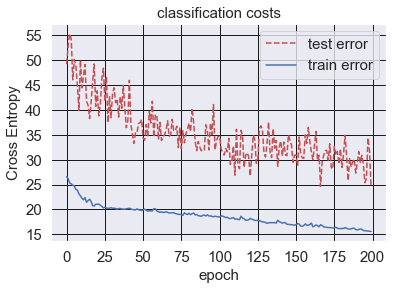

<Figure size 432x288 with 0 Axes>

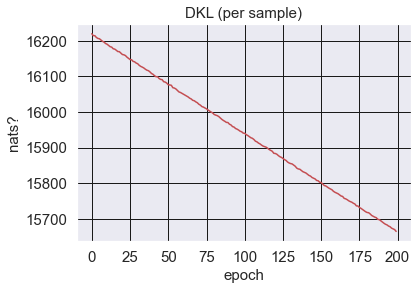

<Figure size 600x400 with 0 Axes>

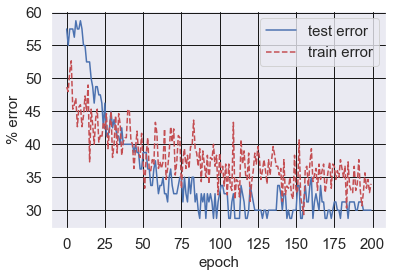

In [18]:
plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')

C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_24556/2913802808.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


<Figure size 600x400 with 0 Axes>

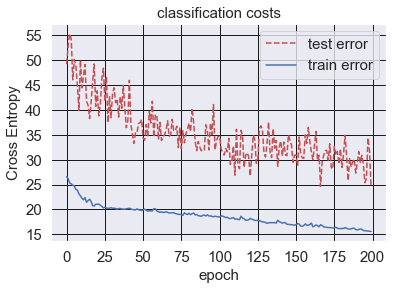

<Figure size 432x288 with 0 Axes>

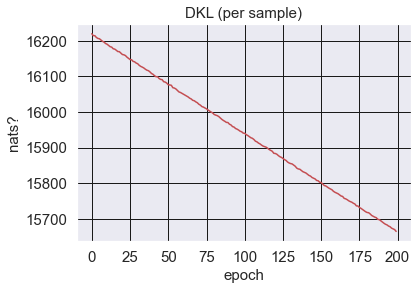

<Figure size 600x400 with 0 Axes>

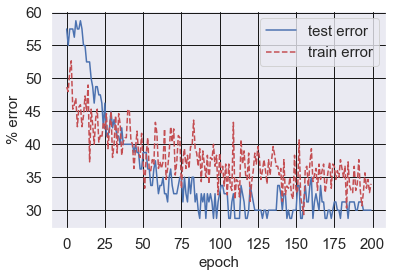

In [19]:

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(pred_cost_train, 'r--')
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(kl_cost_train, 'r')
ax1.set_ylabel('nats?')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax = plt.gca()
plt.title('DKL (per sample)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')


plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')

In [20]:
torch.cuda.empty_cache()

## Loading time

In [21]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib
import copy

models_dir = 'models_weight_uncertainty_COVID150_gaussian'
results_dir = 'results_weight_uncertainty_COVID150_gaussian'

# models_dir = 'models_weight_uncertainty_MC_MNIST_gaussian'
# results_dir = 'results_weight_uncertainty_MC_MNIST_gaussian'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 300
#batch_size = 10
#nb_epochs = 100
log_interval = 1

savemodel_its = [20, 50, 80, 100]
save_dicts = []

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])


transform_covid19 = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=(0, 180)),
        transforms.Resize(image_trans_size),
        transforms.CenterCrop(image_trans_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1)
])
    
    
trainset = torchvision.datasets.ImageFolder(root="../data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="../data/COVID/test", transform=transform_covid19)
num_classes = 2
inputs = 3

use_cuda = torch.cuda.is_available()

# trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
# valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-5
nsamples = 3
########################################################################################
net = Bayes_Net(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=2, batch_size=batch_size,
          Nbatches=(NTrainPointsMNIST/batch_size))


net.load('models_weight_uncertainty_COVID150_gaussian/theta_last.dat') # theta_last.dat



Data:

Network:

Net:
 Creating Net!! 
    Total params: 12.72M
Reading models_weight_uncertainty_COVID150_gaussian/theta_last.dat

  restoring epoch: 199, lr: 0.000001


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_24556/2912214083.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


199

#### 

## inference with sampling on test set

In [22]:
#batch_size = 20

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=4)
test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((80, 2))

Nsamples = 100

net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True

    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))


    Loglike = -49.271309, err = 0.312500



In [23]:
x.size()

torch.Size([10, 1, 64, 64])

In [24]:
import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())
Nsamples = 100
x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

(80, 1, 64, 64)
(80,)


image number: 74
real number: 1


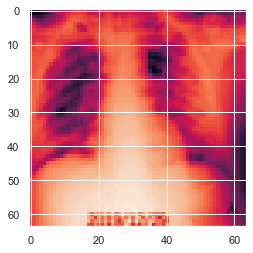

predictions [[0.4053348  0.59466517]]
error 0
predict 1


In [25]:
im_ind = np.random.randint(0, y_dev.shape[0])
#im_ind = 73

print("image number:", im_ind)


x, y = x_dev[im_ind], y_dev[im_ind]
x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)

print("real number:",y)

plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
plt.show()

ims=[]


ims.append(x_rot[:,:,:])


ims = np.concatenate(ims)

net.set_mode_train(False)

y = np.ones(ims.shape[0])*y
ims = np.expand_dims(ims, axis=1)

cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True

predictions = probs.numpy()

print("predictions", predictions)

print("error", err.cpu().numpy())


# predictions.max(axis=1)[0]
# selections = (predictions[:,i] == predictions.max(axis=1))
print("predict", predictions.argmax())

In [26]:
im_ind = np.random.randint(0, y_dev.shape[0])
im_ind

77

In [27]:
valset[im_ind][1]

1

In [28]:
valset.class_to_idx

{'0noncovid': 0, '1covid': 1}

In [29]:
y_true = []
y_pred = []
prob = []
for i in range(0,80):
    x, y = x_dev[i], y_dev[i]
    x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    ims.append(x_rot[:,:,:])
    ims = np.concatenate(ims)
    net.set_mode_train(False)
    y = np.ones(ims.shape[0])*y
    ims = np.expand_dims(ims, axis=1)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()


In [30]:
print(y_pred)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]


In [31]:
prob[0]

array([[0.7120128 , 0.28798717]], dtype=float32)

[[29 11]
 [11 29]]
[29 11 11 29]


Text(66.5, 0.5, 'True')

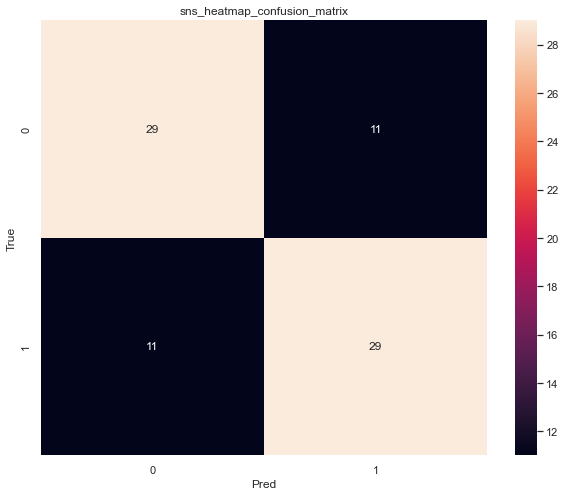

In [32]:
sns.set()

f, ax2 = plt.subplots(figsize = (10, 8),nrows=1)

C2= confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
print(C2)
print(C2.ravel())
sns.heatmap(C2,annot=True)

ax2.set_title('sns_heatmap_confusion_matrix')
ax2.set_xlabel('Pred')
ax2.set_ylabel('True')

In [33]:
"Accuracy: "+str(round((tp+tn)/(tp+fp+fn+tn), 3))

'Accuracy: 0.725'

In [34]:
torch.cuda.empty_cache()

In [35]:
thres = np.arange(0,1,0.001)
thres.shape

(1000,)

In [36]:
print(prob)

[array([[0.7120128 , 0.28798717]], dtype=float32), array([[0.91999984, 0.08000011]], dtype=float32), array([[0.6290299 , 0.37097004]], dtype=float32), array([[0.43030655, 0.56969345]], dtype=float32), array([[0.94, 0.06]], dtype=float32), array([[0.56357515, 0.43642488]], dtype=float32), array([[0.8106674 , 0.18933257]], dtype=float32), array([[0.63322896, 0.36677092]], dtype=float32), array([[0.5178632 , 0.48213676]], dtype=float32), array([[0.7251753 , 0.27482462]], dtype=float32), array([[0.8703338, 0.1296662]], dtype=float32), array([[0.8041813 , 0.19581866]], dtype=float32), array([[0.519131  , 0.48086897]], dtype=float32), array([[0.73368454, 0.26631537]], dtype=float32), array([[0.29998305, 0.7000169 ]], dtype=float32), array([[0.6464189 , 0.35358104]], dtype=float32), array([[0.5646304 , 0.43536955]], dtype=float32), array([[0.5922131, 0.4077869]], dtype=float32), array([[0.62487495, 0.37512496]], dtype=float32), array([[0.558637  , 0.44136298]], dtype=float32), array([[0.69505

In [37]:
prob = np.array(prob)
prob = prob.reshape(80,2)

Text(0.5, 0, 'threshold')

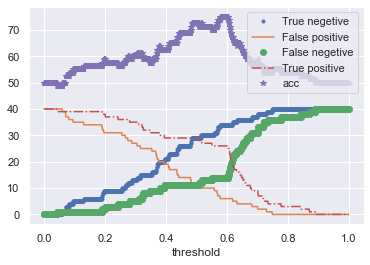

In [38]:
tnl=[]
fpl=[]
fnl=[]
tpl=[]
acc=[]
y_true = np.append(np.zeros(40),np.ones(40))
for j in range(0, thres.shape[0]):
    y_pred=[]
    for i in range(0,prob.shape[0]):
        if prob[i][1] >= thres[j]:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    tnl.append(tn)
    fpl.append(fp)
    fnl.append(fn)
    tpl.append(tp)
    acc.append(round((tp+tn)/(tp+fp+fn+tn), 3))
    
    
tnl = np.array(tnl)
fpl = np.array(fpl)
fnl = np.array(fnl)
tpl = np.array(tpl)
acc = np.array(acc)

plt.plot(thres, tnl, '.')
plt.plot(thres, fpl, '-')
plt.plot(thres, fnl, 'o')
plt.plot(thres, tpl, '-.')
plt.plot(thres, acc*100, '*')
plt.legend(['True negetive', 'False positive','False negetive','True positive', 'acc'])
plt.xlabel("threshold")

In [53]:
mat = np.array([acc, thres,tnl,fpl,fnl,tpl])

In [54]:
c=np.where(acc==np.max(acc))
print('max acc is', acc[c])
print('max of acc is at', c)
print('corr threshold is',thres[c])
print('True negetive is', tnl[c])
print('False positive', fpl[c])
print('False negetive is', fnl[c])
print('True positive is', tpl[c])

max acc is [0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
max of acc is at (array([578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603],
      dtype=int64),)
corr threshold is [0.578 0.579 0.58  0.581 0.582 0.583 0.584 0.585 0.586 0.587 0.588 0.589
 0.59  0.591 0.592 0.593 0.594 0.595 0.596 0.597 0.598 0.599 0.6   0.601
 0.602 0.603]
True negetive is [34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34]
False positive [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
False negetive is [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14]
True positive is [26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26]


In [55]:
mat = pd.DataFrame(mat,  index = [' acc', 'threshold', 'TN', 'FP','FN','TP'])

In [56]:
pd.set_option('display.max_columns', None) 

In [57]:
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
acc,0.5,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500,

In [59]:
tpr = tpl/(tpl+fnl)

In [60]:
fpr = fpl/(fpl+tnl)

In [61]:
print(fpr)
print(tpr)

[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.975 0.925
 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.9   0.9   0.9
 0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.9   0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.85  0.85
 0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85
 0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85
 0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85

In [62]:
xt = np.array([0,0])
yt = np.array([1,1])

In [63]:
def point_distance_line(point,line_point1,line_point2):
    vec1 = line_point1 - point
    vec2 = line_point2 - point
    distance = np.abs(np.cross(vec1,vec2)) / np.linalg.norm(line_point1-line_point2)
    return distance

distances = []

for i in range(0, thres.shape[0]):
    distances.append(point_distance_line(np.array([fpr[i],tpr[i]]), xt, yt))

In [64]:
cd=np.where(distances==np.max(distances))
print(cd)

(array([578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590,
       591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603],
      dtype=int64),)


In [65]:
start = [0,1]
end = [0,1]

0.7324999999999999


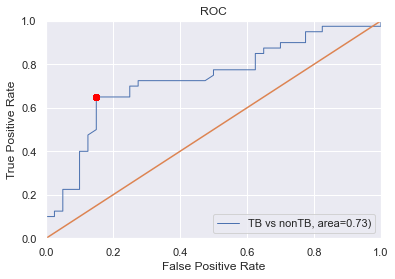

In [66]:
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.plot(fpr, tpr, lw=1, label="TB vs nonTB, area=%0.2f)" % (roc_auc))
plt.plot(start, end)
plt.plot(fpr[cd], tpr[cd], 'o', color = 'red')
plt.xlim([0.00, 1.0])
plt.ylim([0.00, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.savefig(r"./ROC.png")